# Assignment 2

## Abstract

In this Jupyter notebook, we have summarized, tweaked and extended the findings of one of the kernels of a Kaggle Competition titled - "Kobe Bryant Shot Selection". We have tweaked by changing values of the parameters to get better results than the kernel used and extended further by performing Data Cleaning of the original dataset and then trained our model by using XGBoost method. This resulted in achieving a better Log Loss - an evaluation metric for our dataset, than the one obtained by running the kernel. To conclude, the Log Loss obtained in the Kernel was '0.600086' which ranks at 44 and the Log Loss we achieved by tuning is '0.596335' which stands at 10th place in the public leaderboard of the competition.

##### Kaggle competition - Kobe Bryant Shot Selection

The Kaggle competition that we have chosen is - Kobe Bryant Shot Selection - Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

Link to the competition - https://www.kaggle.com/c/kobe-bryant-shot-selection

Link to the kernel - https://www.kaggle.com/hcuny0011/updating-xgboost-giving-logloss-around-0-602

##### XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [1]:
import csv
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df_all=pd.read_csv('data_original.csv')
df_teid=pd.read_csv('sample_submission.csv')

- Reads 'data_original' and 'sample_submission' comma-separated values (csv) file into DataFrame

In [3]:
#split data into training and testing
test_id=df_teid['shot_id'].tolist()

- tolist() is used here to convert column 'shot_id' present in a dataFrame into a list

In [4]:
df_all['shot_made_flag'].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

- 'shot_made_flag' is a binary column having 14232 instances of 0.0 and 11465 instances of 1.0
- The resulting object will be in descending order so that the first element is the most frequently-occurring element

In [5]:
df_all['combined_shot_type'].value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64

- 'combined_shot_type' is a multiclass categorical column having 6 different categories of type integer

In [6]:
df_all['period'].value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

- 'period' is a multiclass categorical column having 7 different categories of type integer

In [7]:
df_all['shot_zone_area'].value_counts()

Center(C)                13455
Right Side Center(RC)     4776
Right Side(R)             4588
Left Side Center(LC)      4044
Left Side(L)              3751
Back Court(BC)              83
Name: shot_zone_area, dtype: int64

- 'shot_zone_area' is a multiclass categorical column having 6 different categories of type integer

In [8]:
df_all['shot_zone_basic'].value_counts()

Mid-Range                12625
Restricted Area           7136
Above the Break 3         5620
In The Paint (Non-RA)     4578
Right Corner 3             387
Left Corner 3              280
Backcourt                   71
Name: shot_zone_basic, dtype: int64

- 'shot_zone_basic' is a multiclass categorical column having 7 different categories of type integer

In [9]:
df_all['shot_type'].value_counts()

2PT Field Goal    24271
3PT Field Goal     6426
Name: shot_type, dtype: int64

- 'shot_type' is a categorical column having 2 different categories of type integer

In [10]:
df_all['opponent'].value_counts()

SAS    1978
PHX    1781
HOU    1666
SAC    1643
DEN    1642
POR    1539
UTA    1490
MIN    1474
GSW    1356
LAC    1285
DAL    1199
MEM    1030
BOS     946
SEA     828
IND     761
PHI     720
ORL     719
DET     715
OKC     677
TOR     664
NYK     657
MIA     627
CHA     620
CLE     619
CHI     610
WAS     600
MIL     586
NOH     581
NJN     520
ATL     519
NOP     344
VAN     246
BKN      55
Name: opponent, dtype: int64

.value_counts() returns a series containing counts of unique values
'opponent' is a multiclass categorical column having 33 different categories of type integer
Excludes NA values by default

In [11]:
#string format into datetime
df_all['game_date'] = pd.to_datetime(df_all['game_date'])

- to_datetime() method helps to convert string Date time into Python Date time object

In [12]:
#if it is a back to back game 
#(df_all['game_date'][100]-df_all['game_date'][1]).days #int
def btb(lst): #0,1
    btb_lst=[0]
    flag=0
    for i in range(1,len(lst)):
        if (lst[i]-lst[i-1]).days==1:
            btb_lst.append(1)
            flag=1
        elif (lst[i]-lst[i-1]).days==0:
            btb_lst.append(flag)
        else:
            flag=0
            btb_lst.append(flag)
    return btb_lst

df_all['btb']=btb(df_all['game_date'])

- If the current game date and previous game date has a difference of 1 then it appends 1 to the list and sets flag=1
- If the current game date and previous game date are same, then it appends current flag value to the list
- If none of the condition satisfies, then it resets flag to 0 and appends 0 to the list

In [13]:
#home court game or not
def homecourt(row):
    if '@' in row:
        return 0
    elif 'vs' in row:
        return 1
    else:
        return 'error'
    


homecourt_label=df_all['matchup'].apply(homecourt)
df_all['homecourt']=homecourt_label

- The function 'homecourt' returns 0 if '@' is found in a row and returns 1 if 'vs' is found in a row
- Else it returns error
- From 'homecourt' function, a new column named 'homecourt' is created of value 0, 1 and error

In [14]:
#game month
#w['female'] = w['female'].map({'female': 1, 'male': 0})
def gamemonth(lst):
    dict_month={'1': 'Jan', '2': 'Feb', '3': 'Mar',
                '4': 'Apr', '5': 'May', '6': 'Jun',
                '7': 'Jul', '8': 'Aug', '9': 'Sep',
                '10': 'Oct', '11': 'Nov', '12': 'Dec'}
    
    splitseries=lst.apply(lambda row :str(row.month))
    
    newseries=splitseries.map(dict_month)
    
    return newseries
    
gamemonth(df_all['game_date']).isnull().values.any() #false
df_all['gamemonth']=gamemonth(df_all['game_date'])

- This function takes 'game_date' which is in date format as input
- Then it applies lambda function on each row to take month number and stores in a variable named 'splitseries'
- Then it maps that month number to their respective month name in dictionary 'dict_month' and returns it
- From above function, a new column 'gamemonth' is created

In [15]:
#if last shot was made
def lastshot(lst):
    last=[0]
    for i in range(1,len(lst)):
        
        if lst[i-1]==0:
            flag=0
            last.append(0)
        elif lst[i-1]==1:
            flag=1
            last.append(1)
        else:
            last.append('unknown') #due to the random test data
    return last

df_all['last_shot_flag']=lastshot(df_all['shot_made_flag'])

- It checks whether the previous shot made is equal to 0, then appends 0
- If previous shot made is 1, then it appends 1
- If none of the above, it appends 'unknown'
- It creates a new column 'last_shot_flag' based on the above condition

In [16]:
#add column secondsToPeriodEnd
df_all['secondsToPeriodEnd'] = 60*df_all['minutes_remaining']+df_all['seconds_remaining']

- Here, a new column 'secondsToPeriodEnd' is added which is the sum of 'minutes remaining' and 'seconds_remaining', converted to seconds by multiplying with 60

In [17]:
#add column secondsFromPeriodEnd
df_all['secondsFromGameStart'] = df_all['period'].astype(int)*12*60 - df_all['secondsToPeriodEnd']

- A new column 'secondsFromGameStart' is added which is the difference of column 'period' converted to seconds by multiplying with 12*60 and column 'secondsToPeriodEnd'

In [18]:
criterion = df_all['shot_id'].map(lambda x: x not in test_id)
criterion1 = df_all['shot_id'].map(lambda x: x in test_id)
df_all_tr=df_all[criterion]
df_all_te=df_all[criterion1]

- The first line checks if the shot_id is not present in test_id dataset and stores it in 'criterion' variable
- The first line checks if the shot_id is present in test_id dataset and stores it in 'criterion1' variable
- New dataFrames 'df_all_tr', df_all_te' are created from 'criterion' and 'criterion1' respectively 

In [19]:
ctg_feature=['combined_shot_type', 
             'shot_id','shot_type', 
             'action_type',
             'shot_zone_area', 'shot_zone_basic', 'playoffs', 'period','opponent','season',
             'homecourt',
             'btb',
             'gamemonth',
            'last_shot_flag'
             ]
num_feature=['loc_x', 'loc_y', 'shot_distance','shot_id','seconds_remaining',
             'secondsToPeriodEnd','secondsFromGameStart']

- Two lists are created here: 'ctg_feature' for storing all the categorical features and 'num_feature' takes all the numerical features

In [20]:
df_ctg = df_all.loc[:, lambda df: ctg_feature]
encoded_ctg=pd.get_dummies(df_ctg).astype(np.int16)

- A new dataFrame 'df_ctg' is created from main dataFrame 'df_all' that contains only those columns which are present in 'ctg_feature' list
- pd.get_dummies function from pandas library creates dummies for 'df_ctg' and stores in 'encoded_ctg'

In [21]:
criterion01 = encoded_ctg['shot_id'].map(lambda x: x not in test_id)
criterion11 = encoded_ctg['shot_id'].map(lambda x: x in test_id)


df_tr_ctg=encoded_ctg[criterion01]
df_te_ctg=encoded_ctg[criterion11]

- The first line checks if the shot_id is 'not' present in test_id dataset and stores it in 'criterion' variable
- The first line checks if the shot_id 'is' present in test_id dataset and stores it in 'criterion1' variable
- New dataFrames 'df_tr_ctg', df_te_ctg' are created from 'criterion' and 'criterion1' respectively

In [22]:
df_tr_num = df_all_tr.loc[:, lambda df: num_feature]
df_te_num = df_all_te.loc[:, lambda df: num_feature]
flag = df_all_tr['shot_made_flag']

- A new dataFrame 'df_tr_num' is created from dataFrame 'df_all_tr' that contains only those columns which are present in 'num_feature' list
- Another dataFrame 'df_te_num' is created from dataFrame 'df_all_te' that contains only those columns which are present in 'num_feature' list
- shot_made_flag value is stored in a variable 'flag'

In [23]:
train=pd.merge(df_tr_ctg, df_tr_num,on='shot_id')

test=pd.merge(df_te_ctg, df_te_num,on='shot_id')

- The above two lines of code merges 'categorical features' dataFrame and 'numerical features' dataFrame on 'shot_id' column for both train and test data

In [24]:
train.shape

(25697, 154)

- There are 25697 observations and 154 characteristics in train dataFrame

In [25]:
#how new features look like
df_all.loc[:, lambda df: ['homecourt','btb','gamemonth','last_shot_flag']]

,homecourt,btb,gamemonth,last_shot_flag
0,0,0,Oct,0
1,0,0,Oct,unknown
2,0,0,Oct,0
3,0,0,Oct,1
4,0,0,Oct,0
5,0,0,Oct,1
6,0,0,Oct,0
7,0,0,Oct,1
8,0,0,Oct,unknown
9,0,0,Oct,1


- It displays 'homecourt','btb','gamemonth','last_shot_flag' columns

In [26]:
X_dtrain, X_deval, y_dtrain, y_deval = train_test_split(train, flag, random_state=2046, test_size=0.15)
prior = 0.4
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
params1 = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,
    'eta': 0.1,
    'max_depth': 3,
    'seed': 2017,
    'silent': 1,
    'gamma':0.005,
    'subsample':0.8,
     'base_score': prior,
    'eval_metric': 'logloss'
}

clf1 = xgb.train(params1, dtrain, 200, watchlist, early_stopping_rounds=50)

[0]	eval-logloss:0.674965
Will train until eval-logloss hasn't improved in 50 rounds.
[1]	eval-logloss:0.664048
[2]	eval-logloss:0.657258
[3]	eval-logloss:0.650059
[4]	eval-logloss:0.643236
[5]	eval-logloss:0.639566
[6]	eval-logloss:0.634409
[7]	eval-logloss:0.630276
[8]	eval-logloss:0.627382
[9]	eval-logloss:0.624279
[10]	eval-logloss:0.621496
[11]	eval-logloss:0.619179
[12]	eval-logloss:0.618018
[13]	eval-logloss:0.616575
[14]	eval-logloss:0.615107
[15]	eval-logloss:0.61381
[16]	eval-logloss:0.612625
[17]	eval-logloss:0.611673
[18]	eval-logloss:0.610787
[19]	eval-logloss:0.610081
[20]	eval-logloss:0.609325
[21]	eval-logloss:0.608787
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.608008
[24]	eval-logloss:0.607603
[25]	eval-logloss:0.60732
[26]	eval-logloss:0.606964
[27]	eval-logloss:0.606663
[28]	eval-logloss:0.606476
[29]	eval-logloss:0.606028
[30]	eval-logloss:0.605751
[31]	eval-logloss:0.60572
[32]	eval-logloss:0.605538
[33]	eval-logloss:0.605303
[34]	eval-logloss:0.605225
[35]	eval

- Running the XGBoost model to train the data based on the parameters used above
- booster [default= gbtree ]: Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
- objective [default=reg:linear]: binary:logistic: logistic regression for binary classification, output probability
- colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
- eta [default=0.3, alias: learning_rate]: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. Range: [0,1]
- max_depth [default=6]: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. Range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist)
- seed [default=0]: Random number seed
- gamma [default=0, alias: min_split_loss]: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. Range: [0,∞]
- subsample [default=1]: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. Range: (0,1]
- base_score [default=0.5]: The initial prediction score of all instances, global bias. For sufficient number of iterations, changing this value will not have too much effect
- eval_metric: 'logloss': negative log-likelihood


- The logloss which is obtained after running the parameters mentioned in the original kernel is 0.600546 

In [27]:
X_dtrain, X_deval, y_dtrain, y_deval = train_test_split(train, flag, random_state=2046, test_size=0.15)
prior = 0.4
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
params2 = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'colsample_bytree': 0.9,
    'eta': 0.2,
    'max_depth': 3,
    'seed': 2017,
    'silent': 1,
    'gamma':0.015,
    'subsample':0.9,
     'base_score': prior,
    'eval_metric': 'logloss'
}

clf2 = xgb.train(params2, dtrain, 200, watchlist, early_stopping_rounds=50)

[0]	eval-logloss:0.662168
Will train until eval-logloss hasn't improved in 50 rounds.
[1]	eval-logloss:0.645299
[2]	eval-logloss:0.636414
[3]	eval-logloss:0.62782
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.618883
[6]	eval-logloss:0.615244
[7]	eval-logloss:0.612843
[8]	eval-logloss:0.611218
[9]	eval-logloss:0.609656
[10]	eval-logloss:0.608756
[11]	eval-logloss:0.60767
[12]	eval-logloss:0.606738
[13]	eval-logloss:0.606651
[14]	eval-logloss:0.60606
[15]	eval-logloss:0.605647
[16]	eval-logloss:0.605375
[17]	eval-logloss:0.604937
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.604054
[20]	eval-logloss:0.603841
[21]	eval-logloss:0.603689
[22]	eval-logloss:0.603587
[23]	eval-logloss:0.603642
[24]	eval-logloss:0.603386
[25]	eval-logloss:0.603254
[26]	eval-logloss:0.603345
[27]	eval-logloss:0.603267
[28]	eval-logloss:0.602899
[29]	eval-logloss:0.602977
[30]	eval-logloss:0.602766
[31]	eval-logloss:0.602596
[32]	eval-logloss:0.60245
[33]	eval-logloss:0.602245
[34]	eval-logloss:0.602218
[35]	eval-l

- Here, we have tweaked the values of few parameters and got a better result
- The parameters and the values tweaked are:
    - 'colsample_bytree': 0.8 - changed from 0.8 to 0.9, this specifies the fraction of columns to be subsampled
    - 'eta': 0.2 - changed from 0.1 to 0.2, results in making boosting process more conservative
    - 'gamma':0.015 - changed from 0.005 to 0.015, The larger the gamma is, the more conservative the algorithm will be
    - 'subsample':0.9 - changed from 0.8 to 0.9, changing it to 0.9 means that XGBoost would randomly sample 90% of the training data prior to growing trees and this will prevent overfitting
- Here, after tweaking the values of parameters, we obtain a better logloss value than the previous iteration which is 0.599687

## Data Cleaning

We felt that the data is not cleaned and is in an improper format, so we tried to cleanse it further by using the method that we used in H2O AutoML thinking that it would help us in achieving a better Log Loss score

In [2]:
import numpy as np
import pandas as pd

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

# Load data and roughly clean it, then sort as game date
df = pd.read_csv("./data_original.csv")
df.drop(['game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name'], axis=1, inplace=True)
df.sort_values('game_date',  inplace=True)
mask = df['shot_made_flag'].isnull()


# Clean data
actiontypes = dict(df.action_type.value_counts())
df['type'] = df.apply(lambda row: row['action_type'] if actiontypes[row['action_type']] > 20\
                          else row['combined_shot_type'], axis=1)
df.drop(['action_type', 'combined_shot_type'], axis=1, inplace=True)

df['away'] = df.matchup.str.contains('@')
df.drop('matchup', axis=1, inplace=True)

df['distance'] = df.apply(lambda row: row['shot_distance'] if row['shot_distance'] <45 else 45, axis=1)

df['time_remaining'] = df.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)
df['last_moments'] = df.apply(lambda row: 1 if row['time_remaining'] < 3 else 0, axis=1)

data = pd.get_dummies(df['type'],prefix="action_type")

features=["away", "period", "playoffs", "shot_type", "shot_zone_area", "shot_zone_basic", "season",
           "shot_zone_range", "opponent", "distance", "minutes_remaining", "last_moments"]
for f in features:
    data = pd.concat([data, pd.get_dummies(df[f], prefix=f),], axis=1)

# Need work on game_date, add this into feature and increse n_estimators can inprove results but waste time and memory 

X = data[~mask]
y = df.shot_made_flag[~mask]

data=pd.read_csv("./data.csv")
data=data.dropna()
data.isna().sum()
data.to_csv("./data_cleansed.csv")

### Extension of the kernel to improve logloss
- To get even more better logloss, we are cleaning the data by eliminating few columns by combining them and dropping a few which are insignificant to obtain the final result
    - First, we have dropped 'game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name'
    - Then, we sorted the values by 'game_date' and then checked for all the null values present in 'shot_made_flag' and stored in 'mask'
    - We have removed 'action_type' and 'combined_shot_type' by checking if the no. of action types are >20
    - Created a new column 'away' which stores all the rows of the 'matchup' column that contain '@' and hence dropped 'matchup'
    - Created a new column 'distance' which stores all the rows in which the value of the 'shot_distance' column is <45
    - Joined 'minutes_remaining' and 'seconds_remaining' into a new column 'time_remaining' by converting minutes to seconds
    - A new column 'last_moments' is created which stores the value of 'time_remaining' column if it is <3 else 0
    - After all the above steps, we get the significant features like "away", "period", "playoffs", "shot_type", "shot_zone_area", "shot_zone_basic", "season", "shot_zone_range", "opponent", "distance", "minutes_remaining", "last_moments" and store them in a list 'features'
    - Negated the null values and stored in 'X', negated the null values in 'shot_made_flag' column and stored in 'y' which is our predictor column
    - Dropped all the missing values present in the data
    - Finally, a new csv file for the cleansed data is exported as 'data_cleansed.csv'
    
    

In [29]:
df_all=pd.read_csv('data_cleansed.csv')
df_teid=pd.read_csv('sample_submission.csv')
#split data into training and testing
test_id=df_teid['shot_id'].tolist()
#string format into datetime
df_all['game_date'] = pd.to_datetime(df_all['game_date'])
#if it is a back to back game
#(df_all['game_date'][100]-df_all['game_date'][1]).days #int
def btb(lst): #0,1
   btb_lst=[0]
   flag=0
   for i in range(1,len(lst)):
#         print("Iteration : ",i)
       if (lst[i]-lst[i-1]).days==1:
#             print (lst[i],lst[i-1])
           btb_lst.append(1)
#             print(btb_lst)
           flag=1
       elif (lst[i]-lst[i-1]).days==0:
           btb_lst.append(flag)
       else:
           flag=0
           btb_lst.append(flag)
   return btb_lst

df_all['btb']=btb(df_all['game_date'])
#home court game or not
def homecourt(row):
   if '@' in row:
       return 0
   elif 'vs' in row:
       return 1
   else:
       return 'error'



homecourt_label=df_all['matchup'].apply(homecourt)
df_all['homecourt']=homecourt_label
#game month
#w['female'] = w['female'].map({'female': 1, 'male': 0})
def gamemonth(lst):
   dict_month={'1': 'Jan', '2': 'Feb', '3': 'Mar',
               '4': 'Apr', '5': 'May', '6': 'Jun',
               '7': 'Jul', '8': 'Aug', '9': 'Sep',
               '10': 'Oct', '11': 'Nov', '12': 'Dec'}

   splitseries=lst.apply(lambda row :str(row.month))
#     print("Split : ", splitseries)

   newseries=splitseries.map(dict_month)
#     print("New : ", newseries)

   return newseries

gamemonth(df_all['game_date']).isnull().values.any() #false
df_all['gamemonth']=gamemonth(df_all['game_date'])

#if last shot was made
def lastshot(lst):
   last=[0]
   for i in range(1,len(lst)):

       if lst[i-1]==0:
           flag=0
           last.append(0)
       elif lst[i-1]==1:
           flag=1
           last.append(1)
       else:
           last.append('unknown') #due to the random test data
   return last

df_all['last_shot_flag']=lastshot(df_all['shot_made_flag'])

#add column secondsToPeriodEnd
df_all['secondsToPeriodEnd'] = 60*df_all['minutes_remaining']+df_all['seconds_remaining']
#add column secondsFromPeriodEnd
df_all['secondsFromGameStart'] = df_all['period'].astype(int)*12*60 - df_all['secondsToPeriodEnd']
criterion = df_all['shot_id'].map(lambda x: x not in test_id)
criterion1 = df_all['shot_id'].map(lambda x: x in test_id)
df_all_tr=df_all[criterion]
df_all_te=df_all[criterion1]

ctg_feature=['combined_shot_type',
            'shot_id','shot_type',
            'action_type',
            'shot_zone_area', 'shot_zone_basic', 'playoffs', 'period','opponent','season',
            'homecourt',
            'btb',
            'gamemonth',
           'last_shot_flag'
            ]
num_feature=['loc_x', 'loc_y', 'shot_distance','shot_id','seconds_remaining',
            'secondsToPeriodEnd','secondsFromGameStart']
df_ctg = df_all.loc[:, lambda df: ctg_feature]
encoded_ctg=pd.get_dummies(df_ctg).astype(np.int16)
criterion01 = encoded_ctg['shot_id'].map(lambda x: x not in test_id)
criterion11 = encoded_ctg['shot_id'].map(lambda x: x in test_id)


df_tr_ctg=encoded_ctg[criterion01]
df_te_ctg=encoded_ctg[criterion11]
df_tr_num = df_all_tr.loc[:, lambda df: num_feature]
df_te_num = df_all_te.loc[:, lambda df: num_feature]
flag = df_all_tr['shot_made_flag']

train=pd.merge(df_tr_ctg, df_tr_num,on='shot_id')

test=pd.merge(df_te_ctg, df_te_num,on='shot_id')

- The same set of code executed before cleaning the data is executed again on the 'data_cleansed.csv'

In [30]:
X_dtrain, X_deval, y_dtrain, y_deval = train_test_split(train, flag, random_state=3000, test_size=0.15)
prior = 0.4
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
params3 = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'colsample_bytree': 0.5,
    'eta': 0.2,
    'max_depth': 4,
    'seed': 2017,
    'silent': 1,
    'gamma':0.3,
    'subsample':0.8,
    'base_score': prior,
    'eval_metric': 'logloss'
}

clf3 = xgb.train(params3, dtrain, 200, watchlist, early_stopping_rounds=50)

[0]	eval-logloss:0.67049
Will train until eval-logloss hasn't improved in 50 rounds.
[1]	eval-logloss:0.661979
[2]	eval-logloss:0.646533
[3]	eval-logloss:0.637959
[4]	eval-logloss:0.63065
[5]	eval-logloss:0.621831
[6]	eval-logloss:0.616167
[7]	eval-logloss:0.612541
[8]	eval-logloss:0.609461
[9]	eval-logloss:0.608067
[10]	eval-logloss:0.607613
[11]	eval-logloss:0.606865
[12]	eval-logloss:0.606089
[13]	eval-logloss:0.604185
[14]	eval-logloss:0.603452
[15]	eval-logloss:0.603042
[16]	eval-logloss:0.602408
[17]	eval-logloss:0.601475
[18]	eval-logloss:0.6009
[19]	eval-logloss:0.600566
[20]	eval-logloss:0.600238
[21]	eval-logloss:0.60018
[22]	eval-logloss:0.599184
[23]	eval-logloss:0.598885
[24]	eval-logloss:0.598829
[25]	eval-logloss:0.598658
[26]	eval-logloss:0.598598
[27]	eval-logloss:0.598501
[28]	eval-logloss:0.598417
[29]	eval-logloss:0.598562
[30]	eval-logloss:0.598612
[31]	eval-logloss:0.59866
[32]	eval-logloss:0.598501
[33]	eval-logloss:0.598246
[34]	eval-logloss:0.598255
[35]	eval-l

- Here, we have tweaked the values of few parameters on the cleansed dat and got the best result
- The parameters and the values tweaked are:
    - 'colsample_bytree': 0.5 - changed from 0.9 to 0.5, this specifies the fraction of columns to be subsampled
    - 'max_depth': 4 - changed from 3 to 4
    - 'gamma':0.015 - changed from 0.005 to 0.015, The larger the gamma is, the more conservative the algorithm will be
    - 'subsample':0.8 - changed from 0.9 to 0.8, changing it to 0.8 means that XGBoost would randomly sample 80% of the training data prior to growing trees and this will prevent overfitting
- Here, after tweaking the values of parameters, we obtained the best logloss value so far than the previous iteration which is 0.596355

[3, 3, 4]
[0.5, 0.8, 0.9]
[0.1, 0.2, 0.2]
[0.8, 0.8, 0.9]
[0.596355, 0.599687, 0.600546]


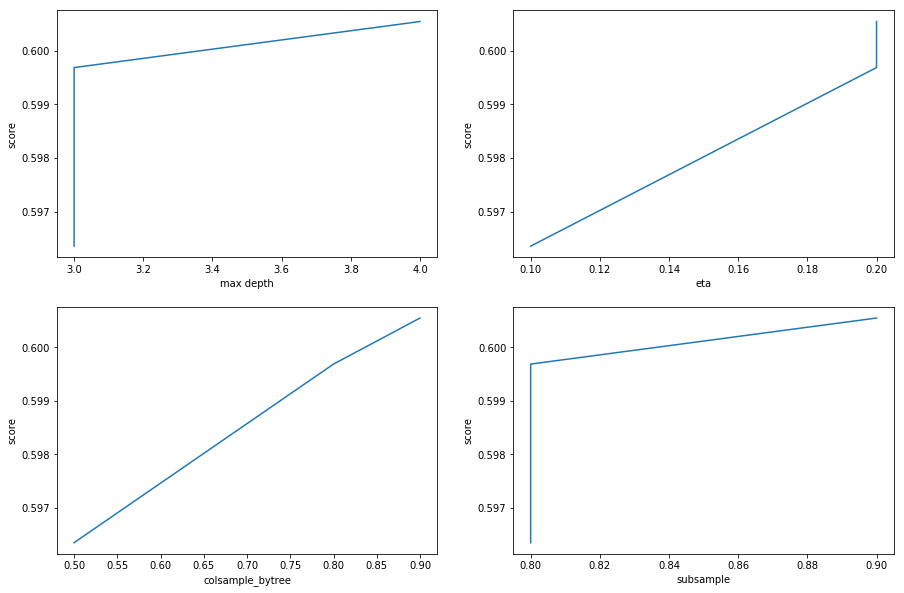

In [34]:
import matplotlib.pyplot as plt

params1.get('max_depth')
max_depth = [params1.get('max_depth'), params2.get('max_depth'), params3.get('max_depth')]
max_depth.sort()
print(max_depth)
colsample_bytree = [params1.get('colsample_bytree'), params2.get('colsample_bytree'), params3.get('colsample_bytree')]
colsample_bytree.sort()
print(colsample_bytree)
eta = [params1.get('eta'), params2.get('eta'), params3.get('eta')]
eta.sort()
print(eta)
subsample = [params1.get('subsample'), params2.get('subsample'), params3.get('subsample')]
subsample.sort()
print(subsample)
score = [clf1.best_score, clf2.best_score, clf3.best_score]
score.sort()
print(score)

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(max_depth, score, scalex=True, scaley=True)
plt.ylabel('score')
plt.xlabel('max depth')

plt.subplot(222)
plt.plot(eta, score)
plt.ylabel('score')
plt.xlabel('eta')

plt.subplot(223)
plt.plot(colsample_bytree, score)
plt.ylabel('score')
plt.xlabel('colsample_bytree')

plt.subplot(224)
plt.plot(subsample, score)
plt.ylabel('score')
plt.xlabel('subsample')

plt.show()

## Conclusion

The kernel we referred has used XGBoost and got a score(Log Loss) of `0.600086`
<img src='Images/image4.PNG' width="1000">

Now, we used it further, and tried to verify if the process performed by the participator was valid. We worked on the kernel and tried to investigate further on how we can improve the score.

* We tweaked the process with our own understanding and tried to better the result
* Through trial and error method, we checked for different values of 
 * colsample_bytree 
 * eta 
 * max_depth 
 * subsample 
 
 Below table summarizes the values and the score that we could produce using the respective combination.
 


Model No. | colsample_bytree | eta | max_depth | subsample|SCORE|Rank|
----------|------------------|-----|-----------|----------|-------|----|
Original  |0.8               |0.1  |3          |0.8       |0.600086|44
1 |0.8|0.1|3|0.8|0.600329|50
2|0.9|0.2|3|0.9|0.599961|41
3|0.5|0.2|4|0.8|0.596335|10(Achieved through self tuning by using XGBoost)
H2O|NA |NA   |NA |NA   |0.34436        |1st(Achieved by H2O)




### Won the Kaggle Competition

<img src='Images/kobewin.jpg' width='700'>

## Contributions Statement

In the above analysis:

- 60% of the work is done by us which comprises below:
    - 2 models of the kernel tuned by us without cleaning
    - 1 model is tuned by Data cleaning
    - EDA on the parameters being passed for the score vs their value
    - Comparison between the models
    - Code explanation of the kernel used

- 40% of the work is taken from the kernel

## Citations

- https://www.kaggle.com/hcuny0011/updating-xgboost-giving-logloss-around-0-602
- https://xgboost.readthedocs.io/en/latest/index.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

## License

<font size="4">MIT License</font>
    
<img src="Images/OSI_Approved_License.png" width="100" align="right"/>

<font size="4">
    
<b>Copyright (c) 2019 PRABHU SUBRAMANIAN, PREETAM JAIN</b>

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
